In [64]:
!python -V

Python 3.11.5


In [65]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
import pyarrow.parquet as pq
import requests

In [66]:
# Download the file
url = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-11.parquet"
response = requests.get(url)
file_path = "green_tripdata_2023-11.parquet"

with open(file_path, "wb") as file:
    file.write(response.content)

# Read the Parquet file
df = pd.read_parquet(file_path)

# Display the dataframe
df.head()


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2023-11-01 00:56:15,2023-11-01 00:59:34,N,1.0,24,238,1.0,0.73,6.5,1.0,0.5,1.80,0.0,NaN,1.0,10.80,1.0,1.0,0.0
1,2,2023-11-01 00:25:06,2023-11-01 00:30:59,N,1.0,74,75,1.0,1.53,9.3,1.0,0.5,2.36,0.0,NaN,1.0,14.16,1.0,1.0,0.0
2,2,2023-11-01 00:40:11,2023-11-01 00:44:08,N,1.0,74,74,1.0,0.70,6.5,1.0,0.5,0.00,0.0,NaN,1.0,9.00,1.0,1.0,0.0
3,2,2023-11-01 00:22:16,2023-11-01 00:33:06,N,1.0,129,82,1.0,1.12,10.7,1.0,0.5,0.00,0.0,NaN,1.0,13.20,2.0,1.0,0.0
4,2,2023-11-01 00:30:48,2023-11-01 00:34:37,N,1.0,82,82,1.0,0.85,6.5,1.0,0.5,0.00,0.0,NaN,1.0,9.00,2.0,1.0,0.0


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64025 entries, 0 to 64024
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               64025 non-null  int32         
 1   lpep_pickup_datetime   64025 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  64025 non-null  datetime64[ns]
 3   store_and_fwd_flag     59315 non-null  object        
 4   RatecodeID             59315 non-null  float64       
 5   PULocationID           64025 non-null  int32         
 6   DOLocationID           64025 non-null  int32         
 7   passenger_count        59315 non-null  float64       
 8   trip_distance          64025 non-null  float64       
 9   fare_amount            64025 non-null  float64       
 10  extra                  64025 non-null  float64       
 11  mta_tax                64025 non-null  float64       
 12  tip_amount             64025 non-null  float64       
 13  t

In [68]:
df.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge'],
      dtype='object')

In [69]:
df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']
df.duration.head()

0   0 days 00:03:19
1   0 days 00:05:53
2   0 days 00:03:57
3   0 days 00:10:50
4   0 days 00:03:49
Name: duration, dtype: timedelta64[ns]

In [70]:
# Convert the duration to minutes
df['duration'] = df['duration'].apply(lambda x: x.total_seconds()/60)
df.duration.head()

0     3.316667
1     5.883333
2     3.950000
3    10.833333
4     3.816667
Name: duration, dtype: float64

In [71]:
# drop the rows which have duration less than 0 and greater than 60 minutes
df = df[(df.duration<60) & (df.duration >=1)]
df.shape

(61094, 21)

In [72]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [73]:
df[categorical] = df[categorical].astype('str')

In [74]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [75]:
train_dicts[0]

{'PULocationID': '24', 'DOLocationID': '238', 'trip_distance': 0.73}

In [76]:
dv = DictVectorizer()
x_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

In [77]:
lr = LinearRegression()
lr.fit(x_train, y_train)

y_pred = lr.predict(x_train)

mean_squared_error(y_train, y_pred, squared=False)

7.823515631589767

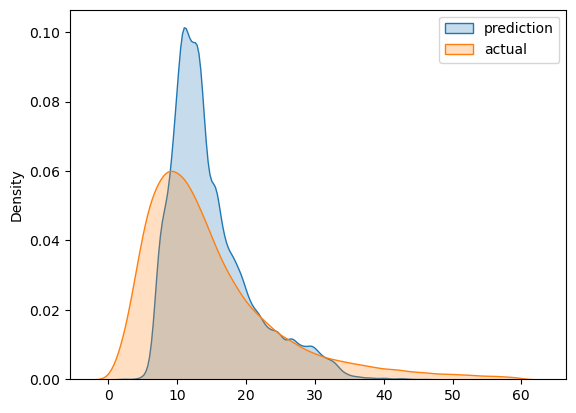

In [78]:
sns.kdeplot(y_pred, label='prediction', fill=True)
sns.kdeplot(y_train, label='actual', fill=True)

plt.legend()
plt.show()

9.861235789536792


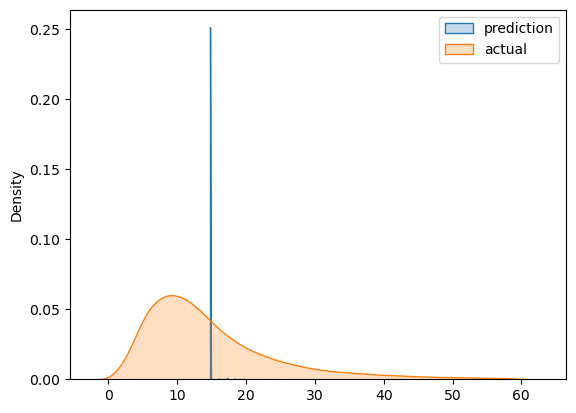

In [79]:
ls = Lasso()
ls.fit(x_train, y_train)

y_pred = ls.predict(x_train)

print(mean_squared_error(y_train, y_pred, squared=False))

sns.kdeplot(y_pred, label='prediction', fill=True)
sns.kdeplot(y_train, label='actual', fill=True)

plt.legend()
plt.show()

In [80]:
from sklearn.model_selection import cross_val_score

# Cross-validation
scores = cross_val_score(ls, x_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print(f'Cross-validated RMSE: {-scores.mean()}')


Cross-validated RMSE: 829.9580186341507


7.813936301009643


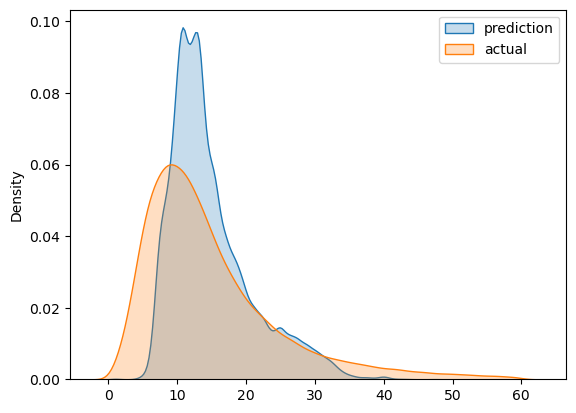

In [81]:
rg = Ridge()
rg.fit(x_train, y_train)

y_pred = rg.predict(x_train)

print(mean_squared_error(y_train, y_pred, squared=False))

sns.kdeplot(y_pred, label='prediction', fill=True)
sns.kdeplot(y_train, label='actual', fill=True)

plt.legend()
plt.show()

In [82]:
def read_dataframe(url):
    # url = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-10.parquet"
    response = requests.get(url)
    file_path = url.split("/")[-1]
    # "green_tripdata_2023-10.parquet"

    with open(file_path, "wb") as file:
        file.write(response.content)
    df = pd.read_parquet(file_path)
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [83]:
df_train = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-10.parquet")
df_val = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-11.parquet")

In [84]:
len(df_train), len(df_val)

(63119, 61105)

In [85]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [86]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [87]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values


In [88]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

6.578512107679445

In [89]:
with open('model/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [90]:
rg = Ridge()
rg.fit(X_train, y_train)

y_pred = rg.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

6.545100747519948

In [91]:
with open('model/ridge.bin', 'wb') as f_out:
    pickle.dump((dv, rg), f_out)

In [92]:
ls = Lasso(0.01)
ls.fit(X_train, y_train)

y_pred = ls.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

8.678532934744714

In [93]:
with open('model/lasso.bin', 'wb') as f_out:
    pickle.dump((dv, ls), f_out)